In [1]:
import numpy as np
import pandas as pd
import spiceypy as spice
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.constants import c
from astropy.time import Time
from astroquery.jplhorizons import Horizons
import rebound

In [53]:
def Furnisher(k):
    '''
    This function is used to load all kernels needed in an operation.
    Comment out kernels not in use and add the ones in use.
    
    Arguments: NA
    Returns: NA
    
    '''
    spice.kclear()
    spice.furnsh('/Users/user/Downloads/naif0009.tls.txt')
    if k == '310+341+435':
            spice.furnsh('/Users/user/Downloads/jup310.bsp')
            spice.furnsh('/Users/user/Downloads/jup341.bsp')
            spice.furnsh('/Users/user/Downloads/de435.bsp')
    elif k == '310+341':
            spice.furnsh('/Users/user/Downloads/jup310.bsp')
            spice.furnsh('/Users/user/Downloads/jup341.bsp')
    elif k == '310+435':
            spice.furnsh('/Users/user/Downloads/de435.bsp')
            spice.furnsh('/Users/user/Downloads/jup310.bsp')
    elif k == '341+435':
            spice.furnsh('/Users/user/Downloads/jup341.bsp')
            spice.furnsh('/Users/user/Downloads/de435.bsp')
    elif k == '310':
            spice.furnsh('/Users/user/Downloads/jup310.bsp')
    elif k == '341':
            spice.furnsh('/Users/user/Downloads/jup341.bsp')
    elif k == '435':
            spice.furnsh('/Users/user/Downloads/de435.bsp')
    pass

In [3]:
def get_spice_function(name,cor,loc):
    """
    This wrapper function automates the creation of objects through the JPL Horizons database. 
    
    Arguments:
    
    name: str
    
    Stipulates the target object in Horizons. The major bodies in the Solar System have an id based on their position.
    Hence '5' refers to Jupiter and '3' to Earth. A single number designator refers to a barycenter and a designator
    such as '599' to the planetary center. For minor bodies in the Solar System, the id_type in the Horizons
    must be changed to "minorbody"
    
    cor: str
    
    Refers to the type of correction that the object has. Available arguments are 'NONE', 'LT','LT+S'
    
    loc: str
    
    Designates the location of observation. Names that start with "g@#" refer to barycenters where the number designates the 
    body that the observer is based at. Hence "g@0" refers to the Solar System barycenter. Also takes Earth location designators.
    Observatories are named after their code. Hence, Pan-Starrs observatory is referred as "f51"

    Returns:
    
    get_target_xyz function
    """    
    def get_target_xyz(t):
        """
        Returns the vectors of the Horizons body at a certain time t.
        
        Arguments:
        
        t: days
        
        Julian date of observation
        
        Returns:
    
        xyz: numpy array
        
        A position vector of the observed object
    
        uvw: numpy array
        
        An instantaneous velocity vector of the observed object
        
        radec: numpy array
        
        The right ascension and declination of the observed object
        """
        
        state,lighttime = spice.spkezr(name,t,'J2000',cor,loc)
        pos,lighttime = spice.spkpos(name,t,'J2000',cor,loc)
        range,ra,dec = spice.recrad(pos) 
        xyz = np.array([state[0],state[1],state[2]])/149597870.7#6.68459e-9
        uvw = np.array([state[3],state[4],state[5]])/149597870.7*24.*3600.#*6.68459e-9
        radec = np.array([ra,dec])
        return xyz,uvw,radec*180/np.pi
    return get_target_xyz

Starting the simulation

In [4]:
def SimStart(bsolar,msolar,iJovian):
    t = 140961664.18440723
    sim = rebound.Simulation()
    k = 0.0172020989484
    sim.G = k**2
    sim.units = ('d', 'AU', 'Msun')
    get_sun = get_spice_function('Sun','NONE','SOLAR SYSTEM BARYCENTER')
    xyz,uvw,radec = get_sun(t) #Adding the Sun
    xyz = xyz
    uvw = (uvw*24*3600)
    sim.add(m=1,x=xyz[0],y=xyz[1],z=xyz[2],vx=uvw[0],vy=uvw[1],vz=uvw[2])
    for i in range(0,len(bsolar)):
        get_planet = get_spice_function(bsolar[i],'NONE','SOLAR SYSTEM BARYCENTER')
        xyz,uvw,radec = get_planet(t) #Adding Jupiter
        xyz = xyz
        uvw = (uvw*24*3600)
        sim.add(m=msolar[i],x=xyz[0],y=xyz[1],z=xyz[2],vx=uvw[0],vy=uvw[1],vz=uvw[2])
    ps = sim.particles
    for j in range(1,len(ps)):
        if j not in iJovian:
            print(ps[j].calculate_orbit(primary=ps[0]))
        else:
            print(ps[j].calculate_orbit(primary=ps[bsolar.index('5')+1]))
    return ps,sim

In [97]:
def SimStart2(bsolar,msolar,iJovian):
    t = 140961664.18440723
    sim = rebound.Simulation()
    k = 0.0172020989484
    sim.G = k**2
    #sim.units = ('d', 'AU', 'Msun')
    #sim.G *= (1+delta)
    #get_sun = geta_spice_function('Sun','NONE','SOLAR SYSTEM BARYCENTER')
    #xyz,uvw,radec = get_sun(t) #Adding the Sun
    #xyz = xyz
    #uvw = (uvw*24*3600)
    sim.add(m=1.)#+delta)#,x=xyz[0],y=xyz[1],z=xyz[2],vx=uvw[0],vy=uvw[1],vz=uvw[2])
    for i in range(0,len(bsolar)):
        get_planet = get_spice_function(bsolar[i],'NONE','SUN')
        xyz,uvw,radec = get_planet(t) #Adding Jupiter
        xyz = xyz
        #uvw = (uvw*24*3600)
        sim.add(m=msolar[i],x=xyz[0],y=xyz[1],z=xyz[2],vx=uvw[0],vy=uvw[1],vz=uvw[2])
    ps = sim.particles
    for j in range(1,len(ps)):
        if j not in iJovian:
            ps[j].calculate_orbit(primary=ps[0])
        elif bsolar[j-1] == 'Moon':
            ps[j].calculate_orbit(primary=ps[bsolar.index('Earth')+1])
        else:
            ps[j].calculate_orbit(primary=ps[bsolar.index('Jupiter')+1])
    sim.move_to_com()
    jupcom = sim.calculate_com(first=8)
    print(jupcom-sim.particles[3])
    return ps,sim

In [182]:
def SimStart3(bsolar,msolar,iJovian):
    t = 140961664.18440723
    sim = rebound.Simulation()
    k = 0.0172020989484
    sim.G = k**2
    #sim.units = ('d', 'AU', 'Msun')
    #sim.G *= (1+delta)
    #get_sun = geta_spice_function('Sun','NONE','SOLAR SYSTEM BARYCENTER')
    #xyz,uvw,radec = get_sun(t) #Adding the Sun
    #xyz = xyz
    #uvw = (uvw*24*3600)
    sim.add(m=1.)#+delta)#,x=xyz[0],y=xyz[1],z=xyz[2],vx=uvw[0],vy=uvw[1],vz=uvw[2])
    for i in range(0,len(bsolar)):
        get_planet = get_spice_function(bsolar[i],'NONE','SUN')
        xyz,uvw,radec = get_planet(t) #Adding Jupiter
        xyz = xyz
        #uvw = (uvw*24*3600)
        sim.add(m=msolar[i],x=xyz[0],y=xyz[1],z=xyz[2],vx=uvw[0],vy=uvw[1],vz=uvw[2])
    ps = sim.particles
    for j in range(1,len(ps)):
        if j not in iJovian:
            print(ps[j].calculate_orbit(primary=ps[0]))
        elif bsolar[j-1] == 'Moon':
            print(ps[j].calculate_orbit(primary=ps[bsolar.index('Earth')+1]))
        else:
            print(ps[j].calculate_orbit(primary=ps[bsolar.index('Jupiter')+1]))
    sim.move_to_com()
    return ps,sim

In [110]:
def Integrator(bsolar,msolar,iJovian,body1,body2):
    ps,sim = SimStart2(bsolar,msolar,iJovian)
    xm = []
    ym = []
    zm = []
    distance = []
    Nout = 100
    year = 365.25 # days
    day = 86400 # s
    tmax = 40*year
    t0 = 140961664.18440723
    times = np.linspace(0, tmax, Nout) # days
    x = np.zeros((len(bsolar)+1,Nout))
    y = np.zeros((len(bsolar)+1,Nout))
    get_ear_an = get_spice_function(body1,'NONE',body2)
    for i, time in enumerate(times):
        tspice = t0 + time*day
        sim.integrate(time)
        for j in range(0,len(bsolar)+1):
            x[j][i] = ps[j].x   # This stores the data which allows us to plot it later
            y[j][i] = ps[j].y
        xyz,uvw,radec = get_ear_an(tspice)
        xm.append(xyz[0])
        ym.append(xyz[1])
        zm.append(xyz[2])
        distance.append(np.sqrt(xm[i]**2 + ym[i]**2 + zm[i]**2))
    return x,y,xm,ym,times,distance

In [120]:
def Integrator2(bsolar,msolar,iJovian,body1,body2):
    ps,sim = SimStart3(bsolar,msolar,iJovian)
    xm = []
    ym = []
    zm = []
    distance = []
    Nout = 100
    year = 365.25 # days
    day = 86400 # s
    tmax = 40*year
    t0 = 140961664.18440723
    times = np.linspace(0, tmax, Nout) # days
    x = np.zeros((len(bsolar)+1,Nout))
    y = np.zeros((len(bsolar)+1,Nout))
    get_ear_an = get_spice_function(body1,'NONE',body2)
    for i, time in enumerate(times):
        tspice = t0 + time*day
        sim.integrate(time)
        for j in range(0,len(bsolar)+1):
            x[j][i] = ps[j].x   # This stores the data which allows us to plot it later
            y[j][i] = ps[j].y
        xyz,uvw,radec = get_ear_an(tspice)
        xm.append(xyz[0])
        ym.append(xyz[1])
        zm.append(xyz[2])
        distance.append(np.sqrt(xm[i]**2 + ym[i]**2 + zm[i]**2))
    return x,y,xm,ym,times,distance

In [196]:
def IntegratorJupBary(bsolar,msolar,iJovian,body1,body2):
    ps,sim = SimStart3(bsolar,msolar,iJovian)
    xm = []
    ym = []
    zm = []
    distance = []
    Nout = 100
    year = 365.25 # days
    day = 86400 # s
    tmax = 40*year
    t0 = 140961664.18440723
    times = np.linspace(0, tmax, Nout) # days
    x = np.zeros(Nout)
    y = np.zeros(Nout)
    get_ear_an = get_spice_function(body1,'NONE',body2)
    for i, time in enumerate(times):
        tspice = t0 + time*day
        sim.integrate(time)
        jupcom = sim.calculate_com(first=bsolar.index('Jupiter')+1)
        #print(jupcom)
        x[i] = ps[-1].x - jupcom.x
        y[i] = ps[-1].y - jupcom.y
        xyz,uvw,radec = get_ear_an(tspice)
        xm.append(xyz[0])
        ym.append(xyz[1])
        zm.append(xyz[2])
        distance.append(np.sqrt(xm[i]**2 + ym[i]**2 + zm[i]**2))
    return x,y,xm,ym,times,distance

In [175]:
def ErrorSourceJupBary(bsolar,mass,iJovian,b1,b2):
    x,y,xm,ym,times,distance = IntegratorJupBary(bsolar,mass,iJovian,b1,b2)
    return np.array(x-xm),np.array(y-ym),times,distance

In [86]:
def ErrorSource(bsolar,mass,iJovian,b1,b2):
    x,y,xm,ym,times,distance = Integrator(bsolar,mass,iJovian,b1,b2)
    if b2 == 'Sun':
        temp = 0
    else:
        temp = bsolar.index(b2)+1
    dist1 = x[bsolar.index(b1)+1] - x[temp]
    dist2 = y[bsolar.index(b1)+1] - y[temp]
    return np.array(dist1-xm),np.array(dist2-ym),times,distance

In [121]:
def ErrorSource2(bsolar,mass,iJovian,b1,b2):
    x,y,xm,ym,times,distance = Integrator2(bsolar,mass,iJovian,b1,b2)
    if b2 == 'Sun':
        temp = 0
    else:
        temp = bsolar.index(b2)+1
    dist1 = x[bsolar.index(b1)+1] - x[temp]
    dist2 = y[bsolar.index(b1)+1] - y[temp]
    return np.array(dist1-xm),np.array(dist2-ym),times,distance

# Match Jupiter from the Sun with just the planets d435

In [126]:
(1.266865341960128E+08+5.959924010272514E+03+3.202739815114734E+03+9.887819980080976E+03+7.179304867611079E+03)/132712440041.939400

0.0009547919090677745

In [148]:
# From 432 (km^3/s^2)
GMEarth = 398600.435420

GMMercuryB = 22031.780000
GMVenusB = 324858.592000
GMEarthB = 403503.235502
GMMarsB = 42828.375214
GMJupiterB = 126712764.133446
GMSaturnB = 37940585.200000
GMUranusB = 5794556.465752
GMNeptuneB = 6836527.100580
GMSun = 132712440041.939400 # Just Sun
GMSunterr = GMSun + GMMercuryB + GMVenusB + GMEarthB + GMMarsB

# From 310

GMJupiter = 1.266865341960128E+08
GMIo = 5.959924010272514E+03
GMEuropa = 3.202739815114734E+03
GMGanymede = 9.887819980080976E+03
GMCallisto = 7.179304867611079E+03
GMAmalthea = 1.487604677404272E-01
GMJupiterB310 = GMJupiter + GMIo + GMEuropa + GMGanymede + GMCallisto + GMAmalthea
GM10310 = 1.327132332639000E+11

GMSaturnB310 = 3.794058500000000E+07
GMUranusB310 = 5.794548600000000E+06
GMNeptuneB310 = 6.836527100580000E+06

# 432 and 310 agree on mass of sun + terrestrial planets to one part in 10**13

In [149]:
(GMSunterr - GM10310)/GMSunterr

1.6671467943686753e-13

# Jupiter and Neptune barycenter masses are the same in 310 and 432!

# Saturn and Uranus vary at one part in a million

In [141]:
(GMJupiterB - GMJupiterB310)/GMJupiterB

-2.8223507797187057e-15

In [142]:
(GMSaturnB - GMSaturnB310)/GMSaturnB

5.27140005685079e-09

In [143]:
(GMUranusB - GMUranusB310)/GMUranusB

1.357438148519429e-06

In [144]:
(GMNeptuneB - GMNeptuneB310)/GMNeptuneB

0.0

In [138]:
# Putting in the terrestrial planet barycenters separately

MMercuryB = GMMercuryB/GMSun
MVenusB = GMVenusB/GMSun
MEarthB = GMEarthB/GMSun
MMarsB = GMMarsB/GMSun
MJupiterB = GMJupiterB/GMSun


In [165]:
# Putting the terrestrial planet barycenters into the Sun

MJupiterB310 = GMJupiterB310/GM10310
MSaturnB310 = GMSaturnB310/GM10310
MUranusB310 = GMUranusB310/GM10310
MNeptuneB310 = GMNeptuneB310/GM10310

MJupiter = GMJupiter/GM10310
MIo = GMIo/GM10310
MEuropa = GMEuropa/GM10310
MGanymede = GMGanymede/GM10310
MCallisto = GMCallisto/GM10310
MAmalthea = GMAmalthea/GM10310

In [117]:
mjbaryallplanets = (1.266865341960128E+08+5.959924010272514E+03+3.202739815114734E+03+9.887819980080976E+03+7.179304867611079E+03)/GMSun
# GM of jupiter + GM of galilean satellites 
mj = 0.0009547919101638659
me = 3.0404326480249294e-06
mv = 2.4478382877865672e-06
mars = 3.2271560375546917e-07
mm = 1.6601141530544803e-07
ms = 0.00028588567270480304
mur = 4.3662496626890934e-05
mnept = 5.1513837726215274e-05
mio = 4.490855574220279e-08
meur = 2.4132928417702382e-08
mga = 7.450560006788226e-08
mcal = 5.409669859576579e-08
man = 0
mpl = 7.350487833457728e-09

# Does just putting in the barycenter of Jupiter and the terrestrial planets into the Sun work? NO

In [162]:
Furnisher('341+435')
xerr,yerr,times,distance = ErrorSource2(['5','6','7','8','Ananke'],[MJupiterB310,MSaturnB310,MUranusB310,MNeptuneB310,0],[5],'Ananke','5')

<rebound.Orbit instance, a=5.201831968728378 e=0.04896257872270177 inc=0.4055249472966209 Omega=0.05673854765072948 omega=0.205586202391974 f=2.7466395538724533>
<rebound.Orbit instance, a=9.574045795990726 e=0.05669161630685209 inc=0.3936038643041836 Omega=0.1038037268845539 omega=1.5489901226058655 f=0.20681655378150543>
<rebound.Orbit instance, a=19.131891707013608 e=0.05010371469975578 inc=0.4130267006196575 Omega=0.03224504179330896 omega=2.9428450868763285 f=-3.425974876895265>
<rebound.Orbit instance, a=29.971909150978313 e=0.008375703680425586 inc=0.3891325474144719 Omega=0.060802691357639174 omega=1.1181394971337442 f=-1.983168185718958>
<rebound.Orbit instance, a=0.14321839949938908 e=0.3495003209486603 inc=2.843150696190117 Omega=1.516844865460753 omega=2.947409680372081 f=-3.8935109112773167>


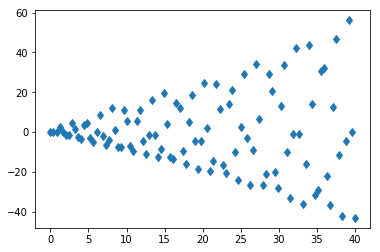

In [163]:
plt.plot(times/365.24,(xerr*1e6)/4,"d")

# Does putting the terrestrials into the Sun and putting in the galilean satellites work?

In [197]:
%%time
Furnisher('310+341+435')
xerr,yerr,times,distance = ErrorSourceJupBary(['6','7','8','Jupiter','Io','Europa','Ganymede','Callisto','Ananke'],[MSaturnB310,MUranusB310,MNeptuneB310,
                        MJupiter,MIo,MEuropa,MGanymede,MCallisto,0],[5,6,7,8,9,10],'Ananke','5')



<rebound.Orbit instance, a=9.574045795990726 e=0.05669161630685209 inc=0.3936038643041836 Omega=0.1038037268845539 omega=1.5489901226058655 f=0.20681655378150543>
<rebound.Orbit instance, a=19.131891707013608 e=0.05010371469975578 inc=0.4130267006196575 Omega=0.03224504179330896 omega=2.9428450868763285 f=-3.425974876895265>
<rebound.Orbit instance, a=29.971909150978313 e=0.008375703680425586 inc=0.3891325474144719 Omega=0.060802691357639174 omega=1.1181394971337442 f=-1.983168185718958>
<rebound.Orbit instance, a=5.202040633232275 e=0.048919602532960155 inc=0.405525145543584 Omega=0.05673845103279668 omega=0.20572257449931072 f=2.746503210188208>
<rebound.Orbit instance, a=0.002821048094873031 e=0.0035623473063570847 inc=0.44547126778140317 Omega=-0.03249725622222026 omega=-1.3208713130787086 f=2.932658389356697>
<rebound.Orbit instance, a=0.004487314392798177 e=0.009057860390144236 inc=0.4399606557297727 Omega=-0.018487620117768045 omega=1.7395885361695322 f=-1.6411684888880587>
<reb

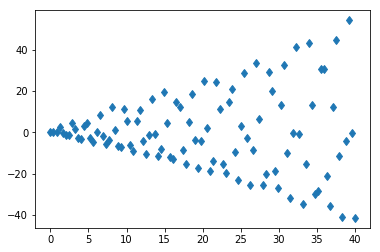

In [198]:
plt.plot(times/365.24,(xerr*1e6)/4,"d")

In [129]:
Furnisher('341+435')
xerr,yerr,times,distance = ErrorSource2(['1','2','3','4','5','6','7','8','9','Ananke'],[mm,mv,me,mars,mj,ms,mur,mnept,mpl,man],[10],'Ananke','5')



<rebound.Particle object, m=4.8480755566023806e-05 x=20.770089032281078 y=-19.021001936899236 z=-8.278822481355249 vx=-0.014672643933426318 vy=0.0023835913095639136 vz=0.0009278432293512262>


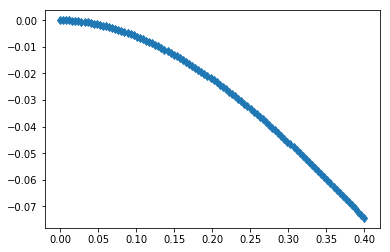

In [192]:
plt.plot(times[:120]/365.24,(xerr[:120]*1e6)/4,"d")

# Match Jupiter from the Sun with just the planets 310

I am using the masses from the paper and only adding the Sun to see if it includes the inner planets. The error is large

In [42]:
1.266865341960128E+08/1.267127641334463E+08

0.9997929968806782

In [116]:
Furnisher('310+341+435')
mj = 0.0009547919101638659*0.9997929968806782
me = 3.0404326480249294e-06
mv = 2.4478382877865672e-06
mars = 3.2271560375546917e-07
mm = 1.6601141530544803e-07
ms = 0.00028588567270480304
mur = 4.3662496626890934e-05
mnept = 5.1513837726215274e-05
mio = 4.490855574220279e-08
meur = 2.4132928417702382e-08
mga = 7.450560006788226e-08
mcal = 5.409669859576579e-08
man = 0
mpl = 7.350487833457728e-09
xerr,yerr,times,distance = ErrorSource(['1','2','3','4','6','7','8','9','Jupiter','Io','Europa','Ganymede','Callisto','Ananke'],[mm,mv,me,mars,ms,mur,mnept,mpl,mj,mio,meur,mga,mcal,0],[10,11,12,13,14],'Ananke','5')



<rebound.Particle object, m=0.0009517588268827908 x=-5.363977281805212 y=1.5678537868377123 z=0.8076868740583638 vx=-0.018048577318673365 vy=-0.006212658873853664 vz=-0.0026337887390944564>


ValueError: 'Earth' is not in list

In [ ]:
plt.plot(times/365.24,(xerr*1e6)/distance,"d")

* Put in all the barycenters except Jupiter from 435

For jupiter:

- Calculate the barycenter using 310 = xbary
- Get the positions and velocities of Jupiter and the galilean satellites FROM the barycenter of Jupiter = deltax
- Put them into the simulation as x = xbary + deltax

In [189]:
Furnisher('310')
sim = rebound.Simulation()

func = get_spice_function('Jupiter','None','0')
xyz,uvw,radec = func(140961664.18440723)
sim.add(m=mj,x=xyz[0],y=xyz[1],z=xyz[2],vx=uvw[0],vy=uvw[1],vz=uvw[2])

func = get_spice_function('Io','None','0')
xyz,uvw,radec = func(140961664.18440723)
sim.add(m=mio, x=xyz[0],y=xyz[1],z=xyz[2],vx=uvw[0],vy=uvw[1],vz=uvw[2])

func = get_spice_function('Europa','None','0')
xyz,uvw,radec = func(140961664.18440723)
sim.add(m=meur, x=xyz[0],y=xyz[1],z=xyz[2],vx=uvw[0],vy=uvw[1],vz=uvw[2])

func = get_spice_function('Ganymede','None','0')
xyz,uvw,radec = func(140961664.18440723)
sim.add(m=mga, x=xyz[0],y=xyz[1],z=xyz[2],vx=uvw[0],vy=uvw[1],vz=uvw[2])

func = get_spice_function('Callisto','None','0')
xyz,uvw,radec = func(140961664.18440723)
sim.add(m=mcal, x=xyz[0],y=xyz[1],z=xyz[2],vx=uvw[0],vy=uvw[1],vz=uvw[2])

sim.move_to_com()
ps = sim.particles
ps[0]

<rebound.Particle object, m=0.0009545885597112752 x=-4.776779158888189e-07 y=3.609914767110922e-07 z=1.656427700558183e-07 vx=5.8663120155620294e-08 vy=-1.5339260889171008e-07 vz=-6.876251550927068e-08>

In [191]:
func = get_spice_function('Jupiter','None','5')
func(140961664.18440723)

(array([-4.77679195e-07,  3.60990911e-07,  1.65642488e-07]),
 array([ 5.86709634e-08, -1.53407160e-07, -6.87692425e-08]),
 array([142.92099107,  15.4641537 ]))

Now try to find the barycenter of Jupiter within one pixel from 

'''
1. Take 435 with the barycenters, don't include 1,2,3,4 and add their masses
into the Sun. See if the error is within a pixel

-For the masses of Neptune... take the GM of Neptune from 435 and divide it from
the mass of the Sun AND the inner planets from the same file.

Does this work within a pixel?

Sun to Jupiter vector

'''

In [23]:
nmj = 0.0009547862387060006
nms = 0.00028588397455573165
nmur = 4.366223727136226e-05
nmnept = 5.151353173307904e-05
nmpl = 7.3504441714156645e-09
xerr,yerr,times = ErrorSource(['5','6','7','8','9'],[nmj,nms,nmur,nmnept,nmpl],[],'5','Sun')


<rebound.Particle object, m=-4.366223727136226e-05 x=-18.023184673954752 y=7.954918918444482 z=3.7389749577064535 vx=-0.001694691769854902 vy=-0.0030793558102794687 vz=-0.0013247118204276955>


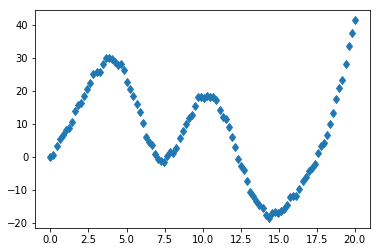

In [24]:
plt.plot(times/365.24,(xerr*1e6)/4,"d")

Okay this didn't work. Now we try to find 5 (Jupiter Barycenter) within one pixel from Earth barycenter.

Trying Ananke again with Earth Moon separate

In [93]:
1/27068703.151194

3.6943033229720506e-08

In [199]:
%%time
Furnisher('310+341+435')
mj = 0.0009547919101638659*0.9997929968806782
me = 3.0034896147890027e-06
mmoon = 3.6943033229720506e-08
mv = 2.4478382877865672e-06
mars = 3.2271560375546917e-07
mm = 1.6601141530544803e-07
ms = 0.00028588567270480304
mur = 4.3662496626890934e-05
mnept = 5.1513837726215274e-05
mio = 4.490855574220279e-08
meur = 2.4132928417702382e-08
mga = 7.450560006788226e-08
mcal = 5.409669859576579e-08
man = 0
mpl = 7.350487833457728e-09
xerr,yerr,times,distance = ErrorSource(['1','2','Earth','Moon','4','6','7','8','9','Jupiter','Io','Europa','Ganymede','Callisto','Ananke'],[mm,mv,me,mmoon,mars,ms,mur,mnept,mpl,mj,mio,meur,mga,mcal,0],[11,12,13,14,15],'Ananke','Earth')



<rebound.Particle object, m=0.0010033096076422423 x=-4.025982717272712 y=0.5139924446850468 z=0.34255007174961744 vx=-0.017882027637642083 vy=-0.005775174050169907 vz=-0.002452383687202985>
CPU times: user 28.3 s, sys: 33.3 ms, total: 28.3 s
Wall time: 28.4 s


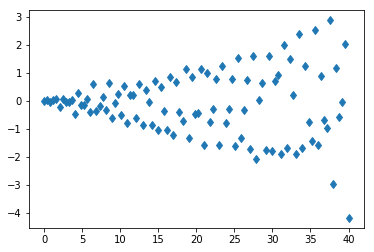

In [200]:
plt.plot(times/365.24,(xerr*1e6)/distance,"d")